### AIRLINES 2008 - EXERCISE

**System:**
    
    CPU: i7-7700HQ 2.80GHz
    Cores: 8
    RAM: 16GB
    OS: Linux Mint 19
    
**Software**
    
    Python: 3.7.9
    Apache Spark: 2.4.0
    
**Tasks:**

    1. Explore and clean the database.
    2. Create a subset of the flights with >2.000 Kms and >2 hours delay.
    3. Define a study group with shorter distance and larger delay.
    4. Study the days of the week for the sorter flights with larger delays.
    5. Define the best pre-known variables (after flight) for predicting flight's delay.

### CODE

**Load packages and data**

In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import StringType
from pyspark import SQLContext
from pyspark.sql.functions import col

conf = SparkConf().setMaster("local").setAppName("Local-Spark")
sc = SparkContext(conf = conf)
sqlContext = SQLContext(sc)

In [2]:
# Read data

dfspark = sqlContext.read.format("csv").option("header","true").option("inferSchema","true").load("/home/agomez/MEGA/Cursos/Linkedin-Spark/base_datos_2008.csv")

##### TASK 1 & 2

Given the task 2 we are interested in creating a subset of the columns 'Distance' (kilometers) and 'ArrDelay' (minutes). First, we need to check that the dataframe defines correctly the value type.

In [3]:
# Get dataframe schema

dfspark.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- Car

In [4]:
# Modify columns type to create subset

dfspark = dfspark.withColumn("ArrDelay",dfspark["ArrDelay"].cast("integer"))

In [120]:
# Clean NaN values in the columns of interest

df2 = dfspark.na.drop(subset = ["ArrDelay","Distance"])

In [121]:
# Create subset

df2 = df2.filter("ArrDelay > 120 and Distance > 2000")

After cleaning and selecting a subset the number of rows is 7397. (df2.count())

##### TASK 3

We need to create a second subset of values with minimum distance but larger delay. For that purpose we will use K-means.

In [7]:
# Load libraries

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

In [31]:
# Subset for ArrDelay and Distance

df_kmeans = df2.select(["ArrDelay","Distance"])

In [32]:
# Transform data to features for KMeans

vectorAssembler = VectorAssembler(inputCols = ["ArrDelay","Distance"], outputCol = "features")
df_kmeans = vectorAssembler.transform(df_kmeans)

In [33]:
df_kmeans.take(2)

[Row(ArrDelay=158, Distance=2298, features=DenseVector([158.0, 2298.0])),
 Row(ArrDelay=189, Distance=2298, features=DenseVector([189.0, 2298.0]))]

In [60]:
# K-Means (fit)

kmeans = KMeans(k=6, seed=1)
model = kmeans.fit(df)

In [38]:
# Load libraries

import matplotlib.pyplot as plt
import pandas as pd

In [122]:
# Transform dataframe to Pandas to plot results

pddf = df2.toPandas()
cluster = model.summary.cluster.toPandas() # extract groups from KMeans

# Join both dataframe
pddf = pddf.join(cluster)

Text(0, 0.5, 'Distance')

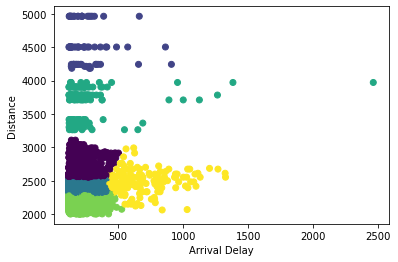

In [123]:
# Plot KMeans

plt.scatter(x=pddf["ArrDelay"],y=pddf["Distance"], c=pddf["prediction"])
plt.xlabel("Arrival Delay")
plt.ylabel("Distance")

In [74]:
# K-Means (Centers)

centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 194.10089463 2632.82703777]
[ 248.84210526 4549.46052632]
[ 190.31388605 2435.3654043 ]
[ 253.30487805 3660.53658537]
[ 183.95863747 2179.67964315]
[ 651.79569892 2495.38172043]


We are going to select the cluster with centers at 651 and 2495. That is the group with larger delay and shorter distance.

##### TASK 4

We can see that the average arrival delay per day of the week is minimum on Tuesday. The maximum delay ocurrs on Wednesday. 

In [124]:
# Filter dataset (group 6 equal value 5) and remove column prediction

pddf = pddf[pddf["prediction"] == 5]
del pddf["prediction"]
pddf

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
54,2008,1,6,7,1158,2225,1857,515,UA,36,...,4,19,0,None,0,14,0,9,0,799
64,2008,1,6,7,729,1310,1054,1653,UA,47,...,3,21,0,None,0,1032,0,0,0,49
68,2008,1,4,5,2245,1336,521,2034,UA,52,...,5,13,0,None,0,73,0,0,0,454
74,2008,1,4,5,1659,851,2039,1221,UA,59,...,5,26,0,None,0,0,488,10,0,0
250,2008,1,4,5,1358,700,2218,1519,US,651,...,13,27,0,None,0,0,418,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7703,2008,12,22,1,1812,725,208,1528,CO,485,...,9,18,0,None,0,0,640,0,0,0
7704,2008,12,22,1,642,2300,1444,659,CO,503,...,10,20,0,None,0,462,0,3,0,0
7706,2008,12,22,1,2214,1425,600,2229,CO,602,...,15,12,0,None,0,451,0,0,0,0
7767,2008,12,19,5,1006,2205,1811,536,CO,369,...,17,20,0,None,0,721,0,34,0,0


In [92]:
# Summaries Days of Week (Arrival Delay)

pddf.groupby(["DayOfWeek"])["ArrDelay"].describe()

,count,mean,std,min,25%,50%,75%,max
DayOfWeek,,,,,,,,
1,21.0,628.714286,171.540416,429.0,465.0,596.0,710.00,1030.0
2,19.0,693.684211,236.263989,434.0,474.5,665.0,867.00,1090.0
3,29.0,659.551724,232.981696,430.0,521.0,605.0,782.00,1325.0
4,21.0,621.857143,182.095383,427.0,527.0,544.0,775.00,1098.0
5,31.0,630.645161,171.528141,419.0,499.5,609.0,722.50,1130.0
6,32.0,704.093750,222.255935,423.0,529.0,718.0,843.75,1267.0
7,33.0,623.757576,203.430582,431.0,484.0,573.0,666.00,1202.0


The results show that the day of the week with the largest delay is Saturday. On the other hand, Thursday is the day with the lowest delay. Also, the number of cases is **larger on the weekend** and Wednesday.

In [93]:
# Summaries Days of Week (Distance)

pddf.groupby(["DayOfWeek"])["Distance"].describe()

,count,mean,std,min,25%,50%,75%,max
DayOfWeek,,,,,,,,
1,21.0,2436.571429,154.105993,2072.0,2338.0,2454.0,2537.0,2704.0
2,19.0,2570.736842,100.943792,2401.0,2511.0,2562.0,2640.0,2762.0
3,29.0,2435.655172,174.611053,2066.0,2311.0,2486.0,2556.0,2704.0
4,21.0,2502.952381,97.418415,2227.0,2446.0,2504.0,2562.0,2677.0
5,31.0,2514.677419,168.363968,2227.0,2399.5,2486.0,2585.5,2994.0
6,32.0,2476.625000,131.053240,2153.0,2404.0,2468.5,2556.0,2724.0
7,33.0,2537.151515,181.478325,2161.0,2447.0,2556.0,2615.0,2979.0


##### TASK 5

In order to define the variables we need to use some machine learning to define the best variables. We need to use some 'Feature selection' method. Since we show during the course that the correlation was strong among a few of the variables and regression appeared to be strongly lineal, I am going to use LDA (Linear Discriminant Analysis). The methodology is going to be 'Forward Selection' that is based in the idea of including one by one the variables and measure the performance to incluid or discard it.

A second option is to use Random Forest.

In [130]:
# Load libraries

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectFromModel

In [125]:
# Remove categorical columns (keep numerical) manually based in our knowledge

pddf = pddf.drop(["Year","Month","DayofMonth","DayOfWeek","Dest","Origin","UniqueCarrier","TailNum","CancellationCode"], axis=1)

In [143]:
# Define all the columns as int32

pddf = pddf.astype(int)

In [145]:
print(pddf.columns)
print(pddf.dtypes)

Index(['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'FlightNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'Cancelled', 'Diverted',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay'],
      dtype='object')
DepTime              int64
CRSDepTime           int64
ArrTime              int64
CRSArrTime           int64
FlightNum            int64
ActualElapsedTime    int64
CRSElapsedTime       int64
AirTime              int64
ArrDelay             int64
DepDelay             int64
Distance             int64
TaxiIn               int64
TaxiOut              int64
Cancelled            int64
Diverted             int64
CarrierDelay         int64
WeatherDelay         int64
NASDelay             int64
SecurityDelay        int64
LateAircraftDelay    int64
dtype: object


In [146]:
clf = LinearDiscriminantAnalysis()
clf.fit(pddf.loc[:, pddf.columns != "ArrDelay"], pddf["ArrDelay"])

LinearDiscriminantAnalysis()

In [147]:
# Feature selection

featureSelection = SelectFromModel(clf)
featureSelection.fit(pddf.loc[:, pddf.columns != "ArrDelay"], pddf["ArrDelay"])

SelectFromModel(estimator=LinearDiscriminantAnalysis())

In [148]:
selectedFeatures = featureSelection.transform(pddf.loc[:, pddf.columns != "ArrDelay"])

In [149]:
selectedFeatures

array([[290,   4,  19],
       [343,   3,  21],
       [298,   5,  13],
       [330,   5,  26],
       [319,  13,  27],
       [330,   8,  17],
       [330,   6,  12],
       [330,   7,  21],
       [300,   9,  11],
       [286,  12,  10],
       [260,   6,  11],
       [315,   8,  83],
       [323,   9,  61],
       [288,   6,  22],
       [298,   4,  17],
       [341,   2,  25],
       [318,   6,  10],
       [327,   8,  15],
       [308,  11,  15],
       [313,   8,  19],
       [295,   5,  17],
       [350,  21,  26],
       [348,   6,  19],
       [310,   6,  15],
       [310,  20,  17],
       [298,   4,  14],
       [298,  13,  16],
       [274,   4,  13],
       [370,   3,  20],
       [327,   4,  28],
       [331,   4,  19],
       [300,   8,  10],
       [295,   5,  10],
       [310,   8,  13],
       [330,   7,  30],
       [270,  14,  35],
       [290,   5,   9],
       [335,   2,  18],
       [342,   7,  24],
       [335,  11,  20],
       [360,  17,  17],
       [335,   9

In [151]:
pddf.loc[:, pddf.columns != "ArrDelay"].columns[featureSelection.get_support()]

Index(['CRSElapsedTime', 'TaxiIn', 'TaxiOut'], dtype='object')

Results:

For the LDA fit, the best variables are 'CRSElapsedTime', 'TaxiIn' and 'TaxiOut' to predict potential delays in the arrival. My result is different to the one given in the solution but in my opinion, is the result for a LDA approach.